### Choose bucketing strategy 
This need to be run before the RBF and NN scripts to define X and y.

In [83]:
import pandas as pd
import numpy as np

df = pd.read_csv("data/wine_quality_merged.csv")

df_trimmed = df[(df['quality'] != 1) & (df['quality'] != 2) & (df['quality'] != 9)]  # Trims empty classes and class 9 (only 5 datapoints)

choose_strategy = 3

if choose_strategy == 1:  # Use current quality labels as class labels
    X = df_trimmed.drop(['type','quality'], axis=1)
    y = df_trimmed['quality'].astype(int)
    print(df_trimmed['quality'].value_counts())   # shows numbers of datapoints that goes into each class

    # # After your choose_strategy == 1 mapping
    # y = y.astype(int)
    # classes_sorted = np.sort(y.unique())
    # class_map = {c: i for i, c in enumerate(classes_sorted)}
    # y = y.map(class_map)

    # # Debug: print class mapping
    # print("Class mapping:", class_map)

    # # Debug: count how many samples per mapped class
    # mapped_counts = y.value_counts().sort_index()
    # print("Number of samples per mapped class:")
    # print(mapped_counts)

elif choose_strategy == 2:   # Manual bucketing into 3 classes
    quality_map = {3: 'bad', 4: 'bad', 5: 'medium', 6: 'medium', 7: 'good', 8: 'good'}
    df_trimmed['quality_bucket_manual'] = df_trimmed['quality'].map(quality_map)
    X = df_trimmed.drop(['type', 'quality', 'quality_bucket_manual'], axis=1)
    y = df_trimmed['quality_bucket_manual'].astype('category').cat.codes
    print(df_trimmed['quality_bucket_manual'].value_counts())   # shows numbers of datapoints that goes into each class

elif choose_strategy == 3:   # Stratified bucketing into 3 classes
    labels = ['bad', 'medium', 'good']
    df_trimmed['quality_bucket_stratified'] = pd.qcut(df_trimmed['quality'], q=3, labels=labels)
    X = df_trimmed.drop(['type', 'quality', 'quality_bucket_stratified'], axis=1)
    y = df_trimmed['quality_bucket_stratified'].astype('category').cat.codes
    print(df_trimmed['quality_bucket_stratified'].value_counts())  # shows numbers of datapoints that goes into each class
    # Print which quality scores go into each bucket
    for label in labels:
        scores = df_trimmed.loc[df_trimmed['quality_bucket_stratified'] == label, 'quality'].unique()
        print(f"{label}: {np.sort(scores)}")



quality_bucket_stratified
medium    2836
bad       2384
good      1272
Name: count, dtype: int64
bad: [3 4 5]
medium: [6]
good: [7 8]


/var/folders/gf/frqp99l15rz69b0dgydv7m380000gn/T/ipykernel_5799/383433194.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trimmed['quality_bucket_stratified'] = pd.qcut(df_trimmed['quality'], q=3, labels=labels)


## Multiclass classification comparison pipeline
### SVM: RBF Kernel classifier (One-versus-Rest), nested cross-validation, y-stratified data:

This pipeline compares four strategies for handling class imbalance in multiclass wine quality prediction:
1) **Plain:** Uses the data as-is, without any balancing.
2) **Balanced:** Reweights classes inversely proportional to their prevalence.
3) **Undersampled:** Randomly undersamples the dominant classes to match the number of underrepresented samples.
4) **SMOTE:** Oversamples minority classes by generating synthetic samples along the line segments joining minority class instances and their nearest neighbors.

Three different strategies are available for defining the multiclass target variable:
- **Strategy 1:** Uses the original wine quality labels (integers 3–9) as class labels.
- **Strategy 2:** Manually buckets the quality scores into three classes: 'bad' (3–4), 'medium' (5–7), and 'good' (8–9).
- **Strategy 3:** Stratifies the quality scores into three equally sized buckets ('bad', 'medium', 'good') using quantiles.

The analysis uses nested cross-validation: the dataset is split *k* times in an outer k-fold loop, and for each outer fold, an inner cross-validation loop is used to tune hyperparameters. The selected hyperparameters are evaluated on the held-out outer test fold, and the average performance metrics across all outer folds are reported. This approach minimizes data leakage and bias from hyperparameter tuning, ensuring a fair comparison between balancing strategies.

Running nested CV for: Plain...
Running nested CV for: Balanced...
Running nested CV for: Undersampled...
Running nested CV for: SMOTE...
              Accuracy  Macro F1  Weighted F1  ROC-AUC (OvR)  F1_class_0  \
Model                                                                      
Plain            0.595     0.339        0.576          0.815       0.000   
Balanced         0.499     0.365        0.511          0.798       0.059   
Undersampled     0.300     0.219        0.322          0.693       0.053   
SMOTE            0.512     0.366        0.522          0.759       0.029   

              F1_class_1  F1_class_2  F1_class_3  F1_class_4  F1_class_5  \
Model                                                                      
Plain              0.155       0.652       0.639       0.434       0.156   
Balanced           0.252       0.615       0.482       0.479       0.302   
Undersampled       0.144       0.466       0.267       0.255       0.130   
SMOTE              0.250 

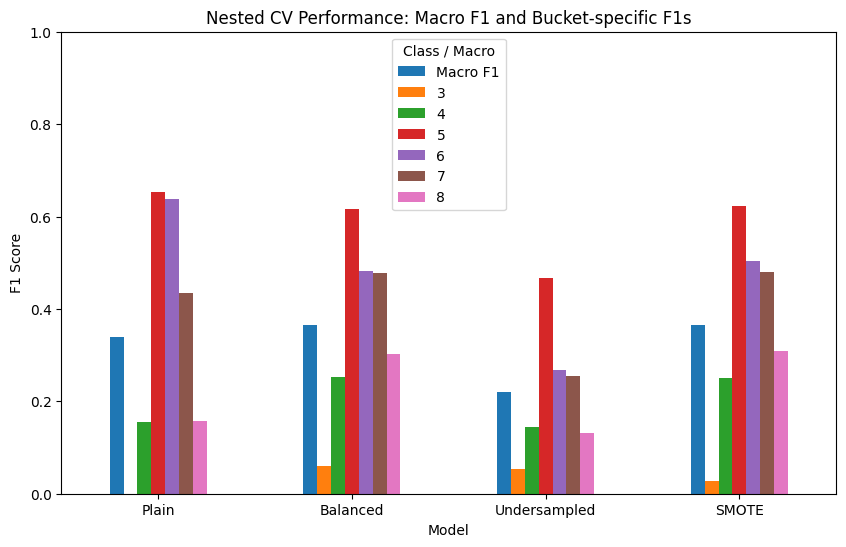

In [79]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter



# --- 2. Define scorers ---
scorers = {
    "accuracy": make_scorer(accuracy_score),
    "macro_f1": make_scorer(f1_score, average="macro"),
    "weighted_f1": make_scorer(f1_score, average="weighted"),
    "roc_auc_ovr": make_scorer(roc_auc_score, multi_class="ovr", needs_proba=True)
}

# --- 3. Define parameter grid ---
param_grid = {
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", 0.1, 0.01],
    "svc__kernel": ["rbf"]
}

# --- 4. Define models (pipelines) ---
# pipelines = {
#     "Plain": Pipeline([("svc", SVC(probability=True, random_state=42))]),
#     "Balanced": Pipeline([("svc", SVC(probability=True, class_weight="balanced", random_state=42))]),
#     "Undersampled": Pipeline([
#         ("under", RandomUnderSampler(random_state=42)),
#         ("svc", SVC(probability=True, random_state=42))
#     ]),
#     "SMOTE": Pipeline([
#         ("smote", SMOTE(random_state=42, k_neighbors=1)),
#         ("svc", SVC(probability=True, random_state=42))
#     ])
# }

pipelines = {
    "Plain": Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(probability=True, random_state=42))
    ]),
    "Balanced": Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(probability=True, class_weight="balanced", random_state=42))
    ]),
    "Undersampled": Pipeline([
        ("under", RandomUnderSampler(random_state=42)),
        ("scaler", StandardScaler()),
        ("svc", SVC(probability=True, random_state=42))
    ]),
    "SMOTE": Pipeline([
        ("smote", SMOTE(random_state=42, k_neighbors=1)),
        ("scaler", StandardScaler()),
        ("svc", SVC(probability=True, random_state=42))
    ])
}

# --- 5. Outer & Inner CV ---
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

def get_mode(lst):
    if not lst:
        return None
    counter = Counter(lst)
    return counter.most_common(1)[0][0]

for name, pipe in pipelines.items():
    print(f"Running nested CV for: {name}...")
    best_params_list = []
    c_list = []
    gamma_list = []
    outer_scores = []

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid = GridSearchCV(
            estimator=clone(pipe),
            param_grid=param_grid,
            scoring="f1_macro",
            cv=inner_cv,
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_params = grid.best_params_
        c_val = best_params["svc__C"]
        gamma_val = best_params["svc__gamma"]
        c_list.append(c_val)
        gamma_list.append(gamma_val)

        # Format gamma for display
        if gamma_val == "scale":
            n_features = X_train.shape[1]
            X_var = X_train.var().mean()
            scale_value = 1.0 / (n_features * X_var) if X_var > 0 else np.nan
            gamma_str = f"gamma: scale = {scale_value:.5g}"
        else:
            gamma_str = f"gamma: {gamma_val}"

        params_str = f"C: {c_val}, {gamma_str}"
        best_params_list.append(params_str)

        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)
        # For multiclass, roc_auc_score needs y_test and y_proba for all classes
        try:
            roc_auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
        except Exception:
            roc_auc = np.nan

        outer_scores.append({
            "accuracy": accuracy_score(y_test, y_pred),
            "macro_f1": f1_score(y_test, y_pred, average="macro"),
            "weighted_f1": f1_score(y_test, y_pred, average="weighted"),
            "roc_auc_ovr": roc_auc,
            "f1_per_class": f1_score(y_test, y_pred, average=None)
        })

    # Aggregate metrics
    avg_scores = {metric: np.mean([fold[metric] for fold in outer_scores]) for metric in outer_scores[0]}
    most_common_c = get_mode(c_list)
    most_common_gamma = get_mode(gamma_list)

    num_classes = len(np.unique(y))
    f1_class_matrix = np.array([fold["f1_per_class"] for fold in outer_scores])  # shape (n_folds, n_classes)
    f1_class_avg = f1_class_matrix.mean(axis=0)  # average F1 per class across folds

    results.append({
        "Model": name,
        "Accuracy": avg_scores["accuracy"],
        "Macro F1": avg_scores["macro_f1"],
        "Weighted F1": avg_scores["weighted_f1"],
        "ROC-AUC (OvR)": avg_scores["roc_auc_ovr"],
        **{f"F1_class_{i}": f1_class_avg[i] for i in range(num_classes)},
        "Most Common C": most_common_c,
        "Most Common gamma": most_common_gamma
    })

df_results = pd.DataFrame(results).set_index("Model")
pd.set_option("display.precision", 3)
print(df_results)

if choose_strategy == 1:
    # Map class indices 0-5 → original quality scores 3-8
    class_names = [str(i) for i in range(3, 9)]
elif choose_strategy in [2, 3]:
    # Map class indices 0-2 → ['bad', 'medium', 'good']
    class_names = ['bad', 'medium', 'good']

# Columns to plot: Macro F1 + all bucket-specific F1s
f1_class_cols = [col for col in df_results.columns if col.startswith("F1_class_")]
rename_dict = {old: new for old, new in zip(f1_class_cols, class_names)}
# Apply renaming
df_results.rename(columns=rename_dict, inplace=True)

# --- 6. Plot ---
cols_to_plot = ["Macro F1"] + class_names
df_results[cols_to_plot].plot(kind="bar", figsize=(10,6))
plt.title("Nested CV Performance: Macro F1 and Bucket-specific F1s")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(title="Class / Macro")
plt.show()


# df_results[["Macro F1", "ROC-AUC (OvR)"]].plot(kind="bar", figsize=(8,5))
# plt.title("Multiclass SVC Performance (Nested CV)")
# plt.ylabel("Score")
# plt.ylim(0,1)
# plt.show()

# Export results to LaTeX table
# with open(f"df_results_multiclass_rbf_{str(choose_strategy)}.tex", "w") as f:
#     f.write(df_results.to_latex(float_format="%.3f"))

## Multiclass classification
### Neural network

This pipeline deploys a feedforward Neural Network

Running nested CV for: Plain...
Running nested CV for: Balanced...
Running nested CV for: Undersampled...
Running nested CV for: SMOTE...
              Accuracy  Macro F1  Weighted F1  ROC-AUC (OvR)  F1_class_0  \
Model                                                                      
Plain            0.585     0.562        0.573          0.748       0.675   
Balanced         0.561     0.547        0.538          0.747       0.675   
Undersampled     0.515     0.515        0.507          0.708       0.624   
SMOTE            0.563     0.551        0.541          0.761       0.698   

              F1_class_1  F1_class_2  \
Model                                  
Plain              0.529       0.483   
Balanced           0.419       0.547   
Undersampled       0.404       0.518   
SMOTE              0.403       0.553   

                                         Best Params (per fold)  
Model                                                            
Plain         lr=0.01, max_epoch

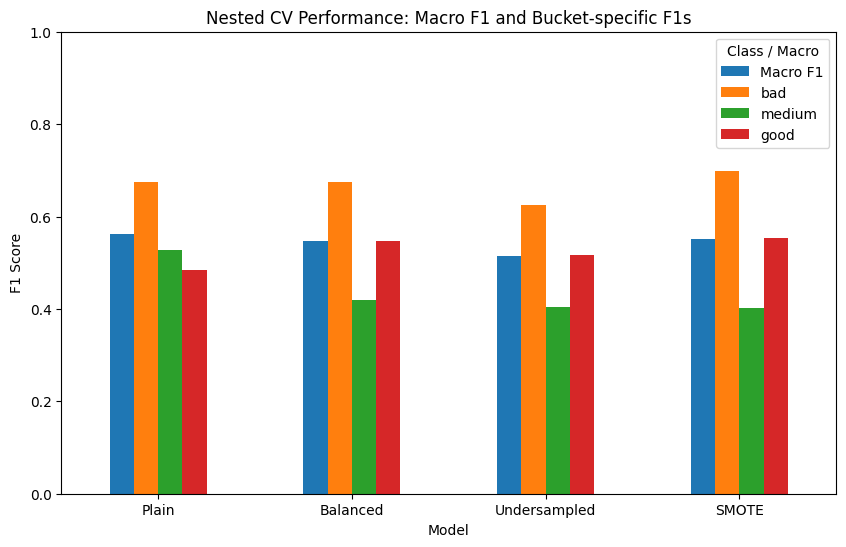

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

# After your choose_strategy code
if choose_strategy == 1:
    # Map 3-8 to 0-5
    y = y.astype(int)
    classes_sorted = np.sort(y.unique())
    class_map = {c: i for i, c in enumerate(classes_sorted)}
    y = y.map(class_map)
    #print("Class mapping:", class_map)

else:  # bucketed strategies 2 or 3
    y = y.astype('category').cat.codes.astype(int)

# -----------------------
# 1. Define NN
# -----------------------
class SimpleMulticlassNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        return self.fc3(X)  # logits for CrossEntropyLoss


# -----------------------
# 2. Helper functions
# -----------------------
def prettify_params(params_dict):
    pretty = []
    for k, v in params_dict.items():
        key = k.replace("net__", "")
        pretty.append(f"{key}={v}")
    return ", ".join(pretty)


def get_mode(lst):
    if not lst:
        return None
    counter = Counter(lst)
    return counter.most_common(1)[0][0]


# -----------------------
# 3. Data (example)
# -----------------------
# X = df.drop(columns=["quality"])
# y = df["quality"]
n_classes = len(np.unique(y))
n_features = X.shape[1]


# -----------------------
# 4. Base NN factory
# -----------------------
def make_net(class_weight=None):
    criterion = nn.CrossEntropyLoss(weight=class_weight)
    return NeuralNetClassifier(
        module=SimpleMulticlassNN,
        module__input_dim=n_features,
        module__hidden_dim=32,
        module__output_dim=n_classes,
        max_epochs=20,
        lr=0.01,
        optimizer=torch.optim.Adam,
        criterion=criterion,
        verbose=0,
    )


# -----------------------
# 5. Pipelines
# -----------------------
to_float32 = FunctionTransformer(lambda x: x.astype(np.float32))
pipelines = {
    "Plain": Pipeline([
        ("scale", StandardScaler()),
        ("to_float32", to_float32),
        ("net", make_net()),
    ]),
    "Balanced": Pipeline([
        ("scale", StandardScaler()),
        ("to_float32", to_float32),
        ("net", make_net(class_weight=torch.tensor(
            (len(y) / (n_classes * np.bincount(y))).astype(np.float32)
        ))),
    ]),
    "Undersampled": Pipeline([
        ("under", RandomUnderSampler(random_state=42)),
        ("scale", StandardScaler()),
        ("to_float32", to_float32),
        ("net", make_net()),
    ]),
    "SMOTE": Pipeline([
        ("smote", SMOTE(random_state=42, k_neighbors=1)),
        ("scale", StandardScaler()),
        ("to_float32", to_float32),
        ("net", make_net()),
    ]),
}


# -----------------------
# 6. Nested CV setup
# -----------------------
param_grid = {
    "net__lr": [0.001, 0.01],
    "net__max_epochs": [20, 40],
    "net__module__hidden_dim": [16, 32, 64],
}

# min_class_count = y.value_counts().min()
# outer_splits = min(5, min_class_count)
# inner_splits = min(3, min_class_count)
# outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
# inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

# -----------------------
# 7. Run nested CV
# -----------------------
for name, pipe in pipelines.items():
    print(f"Running nested CV for: {name}...")
    best_params_list = []
    outer_scores = []

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring="f1_macro",
            cv=inner_cv,
            n_jobs=-1,
            refit=True
        )
        grid.fit(X_train, y_train)

        best_params = grid.best_params_
        best_params_list.append(prettify_params(best_params))

        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)

        try:
            roc_auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
        except Exception:
            roc_auc = np.nan

        outer_scores.append({
            "accuracy": accuracy_score(y_test, y_pred),
            "macro_f1": f1_score(y_test, y_pred, average="macro"),
            "weighted_f1": f1_score(y_test, y_pred, average="weighted"),
            "roc_auc_ovr": roc_auc,
            "f1_per_class": f1_score(y_test, y_pred, average=None)
        })

    avg_scores = {metric: np.mean([fold[metric] for fold in outer_scores]) for metric in outer_scores[0]}

    num_classes = len(np.unique(y))
    f1_class_matrix = np.array([fold["f1_per_class"] for fold in outer_scores])  # shape (n_folds, n_classes)
    f1_class_avg = f1_class_matrix.mean(axis=0)  # average F1 per class across folds

    results.append({
        "Model": name,
        "Accuracy": avg_scores["accuracy"],
        "Macro F1": avg_scores["macro_f1"],
        "Weighted F1": avg_scores["weighted_f1"],
        "ROC-AUC (OvR)": avg_scores["roc_auc_ovr"],
        **{f"F1_class_{i}": f1_class_avg[i] for i in range(num_classes)},
        "Best Params (per fold)": "; ".join(best_params_list),
    })


# -----------------------
# 8. Results
# -----------------------
df_results = pd.DataFrame(results).set_index("Model")
pd.set_option("display.precision", 3)
print(df_results)

if choose_strategy == 1:
    # Map class indices 0-5 → original quality scores 3-8
    class_names = [str(i) for i in range(3, 9)]
elif choose_strategy in [2, 3]:
    # Map class indices 0-2 → ['bad', 'medium', 'good']
    class_names = ['bad', 'medium', 'good']

# Columns to plot: Macro F1 + all bucket-specific F1s
f1_class_cols = [col for col in df_results.columns if col.startswith("F1_class_")]
rename_dict = {old: new for old, new in zip(f1_class_cols, class_names)}
# Apply renaming
df_results.rename(columns=rename_dict, inplace=True)

cols_to_plot = ["Macro F1"] + class_names
df_results[cols_to_plot].plot(kind="bar", figsize=(10,6))
plt.title("Nested CV Performance: Macro F1 and Bucket-specific F1s")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(title="Class / Macro")
plt.show()

# df_results[["Macro F1", "ROC-AUC (OvR)"]].plot(kind="bar", figsize=(8,5))
# plt.title("Multiclass NN Performance (Nested CV)")
# plt.ylabel("Score")
# plt.ylim(0,1)
# plt.show()

# Export results to LaTeX table
with open(f"df_results_multiclass_nn_{str(choose_strategy)}.tex", "w") as f:
    f.write(df_results.to_latex(float_format="%.3f"))

# DO NOT USE BELOW!!!

Running nested CV for: Plain...
Running nested CV for: Balanced...
Running nested CV for: Undersampled...
Running nested CV for: SMOTE...
              Accuracy  Macro F1  Weighted F1  ROC-AUC (OvR)  F1_class_0  \
Model                                                                      
Plain            0.592     0.561        0.577          0.752       0.686   
Balanced         0.559     0.541        0.526          0.747       0.670   
Undersampled     0.547     0.544        0.538          0.725       0.666   
SMOTE            0.562     0.550        0.540          0.761       0.699   

              F1_class_1  F1_class_2  \
Model                                  
Plain              0.541       0.456   
Balanced           0.389       0.564   
Undersampled       0.433       0.532   
SMOTE              0.401       0.549   

                                         Best Params (per fold)  
Model                                                            
Plain         lr=0.01, max_epoch

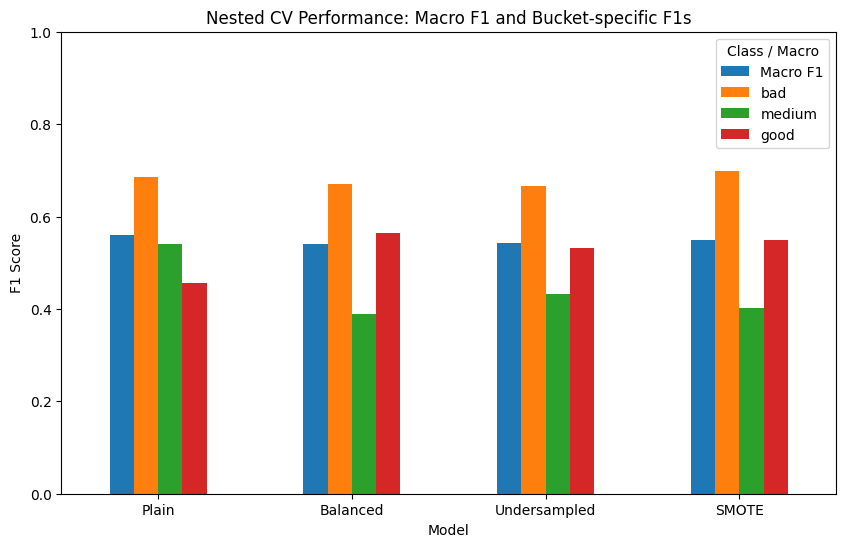

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier

# After your choose_strategy code
if choose_strategy == 1:
    # Map 3-8 to 0-5
    y = y.astype(int)
    classes_sorted = np.sort(y.unique())
    class_map = {c: i for i, c in enumerate(classes_sorted)}
    y = y.map(class_map)
    #print("Class mapping:", class_map)

else:  # bucketed strategies 2 or 3
    y = y.astype('category').cat.codes.astype(int)

# -----------------------
# 1. Define NN
# -----------------------
class SimpleMulticlassNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=10, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = F.relu(self.fc2(X))
        X = self.dropout(X)
        return self.fc3(X)  # logits for CrossEntropyLoss



# -----------------------
# 2. Helper functions
# -----------------------
def prettify_params(params_dict):
    pretty = []
    for k, v in params_dict.items():
        key = k.replace("net__", "")
        pretty.append(f"{key}={v}")
    return ", ".join(pretty)


def get_mode(lst):
    if not lst:
        return None
    counter = Counter(lst)
    return counter.most_common(1)[0][0]


# -----------------------
# 3. Data (example)
# -----------------------
# X = df.drop(columns=["quality"])
# y = df["quality"]
n_classes = len(np.unique(y))
n_features = X.shape[1]


# -----------------------
# 4. Base NN factory
# -----------------------
def make_net(class_weight=None):
    criterion = nn.CrossEntropyLoss(weight=class_weight)
    return NeuralNetClassifier(
        module=SimpleMulticlassNN,
        module__input_dim=n_features,
        module__hidden_dim=32,
        module__output_dim=n_classes,
        max_epochs=20,
        lr=0.01,
        optimizer=torch.optim.Adam,
        criterion=criterion,
        optimizer__weight_decay=0.0,  # L2 regularization
        module__dropout=0.0,          # default, can be tuned
        verbose=0,
    )


# -----------------------
# 5. Pipelines
# -----------------------
to_float32 = FunctionTransformer(lambda x: x.astype(np.float32))
pipelines = {
    "Plain": Pipeline([
        ("scale", StandardScaler()),
        ("to_float32", to_float32),
        ("net", make_net()),
    ]),
    "Balanced": Pipeline([
        ("scale", StandardScaler()),
        ("to_float32", to_float32),
        ("net", make_net(class_weight=torch.tensor(
            (len(y) / (n_classes * np.bincount(y))).astype(np.float32)
        ))),
    ]),
    "Undersampled": Pipeline([
        ("under", RandomUnderSampler(random_state=42)),
        ("scale", StandardScaler()),
        ("to_float32", to_float32),
        ("net", make_net()),
    ]),
    "SMOTE": Pipeline([
        ("smote", SMOTE(random_state=42, k_neighbors=1)),
        ("scale", StandardScaler()),
        ("to_float32", to_float32),
        ("net", make_net()),
    ]),
}


# -----------------------
# 6. Nested CV setup
# -----------------------
param_grid = {
    "net__lr": [0.001, 0.01],
    "net__max_epochs": [20, 40],
    "net__module__hidden_dim": [16, 32, 64],
    "net__module__dropout": [0.0, 0.2, 0.4],
    "net__optimizer__weight_decay": [0.0, 1e-4, 1e-3],
}

# min_class_count = y.value_counts().min()
# outer_splits = min(5, min_class_count)
# inner_splits = min(3, min_class_count)
# outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)
# inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=42)

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

results = []

# -----------------------
# 7. Run nested CV
# -----------------------
for name, pipe in pipelines.items():
    print(f"Running nested CV for: {name}...")
    best_params_list = []
    outer_scores = []

    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            scoring="f1_macro",
            cv=inner_cv,
            n_jobs=-1,
            refit=True
        )
        grid.fit(X_train, y_train)

        best_params = grid.best_params_
        best_params_list.append(prettify_params(best_params))

        y_pred = grid.predict(X_test)
        y_proba = grid.predict_proba(X_test)

        try:
            roc_auc = roc_auc_score(y_test, y_proba, multi_class="ovr")
        except Exception:
            roc_auc = np.nan

        outer_scores.append({
            "accuracy": accuracy_score(y_test, y_pred),
            "macro_f1": f1_score(y_test, y_pred, average="macro"),
            "weighted_f1": f1_score(y_test, y_pred, average="weighted"),
            "roc_auc_ovr": roc_auc,
            "f1_per_class": f1_score(y_test, y_pred, average=None)
        })

    avg_scores = {metric: np.mean([fold[metric] for fold in outer_scores]) for metric in outer_scores[0]}

    num_classes = len(np.unique(y))
    f1_class_matrix = np.array([fold["f1_per_class"] for fold in outer_scores])  # shape (n_folds, n_classes)
    f1_class_avg = f1_class_matrix.mean(axis=0)  # average F1 per class across folds

    results.append({
        "Model": name,
        "Accuracy": avg_scores["accuracy"],
        "Macro F1": avg_scores["macro_f1"],
        "Weighted F1": avg_scores["weighted_f1"],
        "ROC-AUC (OvR)": avg_scores["roc_auc_ovr"],
        **{f"F1_class_{i}": f1_class_avg[i] for i in range(num_classes)},
        "Best Params (per fold)": "; ".join(best_params_list),
    })


# -----------------------
# 8. Results
# -----------------------
df_results = pd.DataFrame(results).set_index("Model")
pd.set_option("display.precision", 3)
print(df_results)

if choose_strategy == 1:
    # Map class indices 0-5 → original quality scores 3-8
    class_names = [str(i) for i in range(3, 9)]
elif choose_strategy in [2, 3]:
    # Map class indices 0-2 → ['bad', 'medium', 'good']
    class_names = ['bad', 'medium', 'good']

# Columns to plot: Macro F1 + all bucket-specific F1s
f1_class_cols = [col for col in df_results.columns if col.startswith("F1_class_")]
rename_dict = {old: new for old, new in zip(f1_class_cols, class_names)}
# Apply renaming
df_results.rename(columns=rename_dict, inplace=True)

cols_to_plot = ["Macro F1"] + class_names
df_results[cols_to_plot].plot(kind="bar", figsize=(10,6))
plt.title("Nested CV Performance: Macro F1 and Bucket-specific F1s")
plt.ylabel("F1 Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(title="Class / Macro")
plt.show()

# df_results[["Macro F1", "ROC-AUC (OvR)"]].plot(kind="bar", figsize=(8,5))
# plt.title("Multiclass NN Performance (Nested CV)")
# plt.ylabel("Score")
# plt.ylim(0,1)
# plt.show()

# Export results to LaTeX table
# with open(f"df_results_multiclass_nn_{str(choose_strategy)}.tex", "w") as f:
#     f.write(df_results.to_latex(float_format="%.3f"))